![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import time

# Caminhos atualizados
filename_features = r"C:\Users\Zghos\Desktop\CursoEBAC\CientistaDados\Mod17\UCI HAR Dataset\features.txt"
filename_labels = r"C:\Users\Zghos\Desktop\CursoEBAC\CientistaDados\Mod17\UCI HAR Dataset\activity_labels.txt"

filename_subtrain = r"C:\Users\Zghos\Desktop\CursoEBAC\CientistaDados\Mod17\UCI HAR Dataset\train\subject_train.txt"
filename_xtrain = r"C:\Users\Zghos\Desktop\CursoEBAC\CientistaDados\Mod17\UCI HAR Dataset\train\X_train.txt"
filename_ytrain = r"C:\Users\Zghos\Desktop\CursoEBAC\CientistaDados\Mod17\UCI HAR Dataset\train\y_train.txt"

filename_subtest = r"C:\Users\Zghos\Desktop\CursoEBAC\CientistaDados\Mod17\UCI HAR Dataset\test\subject_test.txt"
filename_xtest = r"C:\Users\Zghos\Desktop\CursoEBAC\CientistaDados\Mod17\UCI HAR Dataset\test\X_test.txt"
filename_ytest = r"C:\Users\Zghos\Desktop\CursoEBAC\CientistaDados\Mod17\UCI HAR Dataset\test\y_test.txt"

# Carregar os nomes das colunas
features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep=r"\s+").squeeze("columns")

# Verificar e renomear colunas duplicadas
if features.duplicated().any():
    print("Duplicatas encontradas em 'features'. Renomeando para evitar problemas.")
    features = features + "_" + features.groupby(features).cumcount().astype(str)

# Verificar novamente se as duplicatas foram removidas
print(features.duplicated().sum(), "duplicatas restantes após renomeação.")

# Carregar os outros dados
labels = pd.read_csv(filename_labels, sep=r"\s+", header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id']).squeeze("columns")
X_train = pd.read_csv(filename_xtrain, sep=r"\s+", header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id']).squeeze("columns")
X_test = pd.read_csv(filename_xtest, sep=r"\s+", header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

Duplicatas encontradas em 'features'. Renomeando para evitar problemas.
0 duplicatas restantes após renomeação.


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

,Componente,Variância Explicada (Sem Padronização),Variância Explicada Acumulada (Sem Padronização),Variância Explicada (Com Padronização),Variância Explicada Acumulada (Com Padronização)
0,1,0.625544,0.625544,0.507812,0.507812
1,2,0.049130,0.674675,0.065807,0.573619
2,3,0.041215,0.715889,0.028064,0.601683
3,4,0.018750,0.734639,0.025040,0.626722
4,5,0.016949,0.751587,0.018883,0.645605
...,...,...,...,...,...
556,557,0.000000,1.000000,0.000000,1.000000
557,558,0.000000,1.000000,0.000000,1.000000
558,559,0.000000,1.000000,0.000000,1.000000
559,560,0.000000,1.000000,0.000000,1.000000


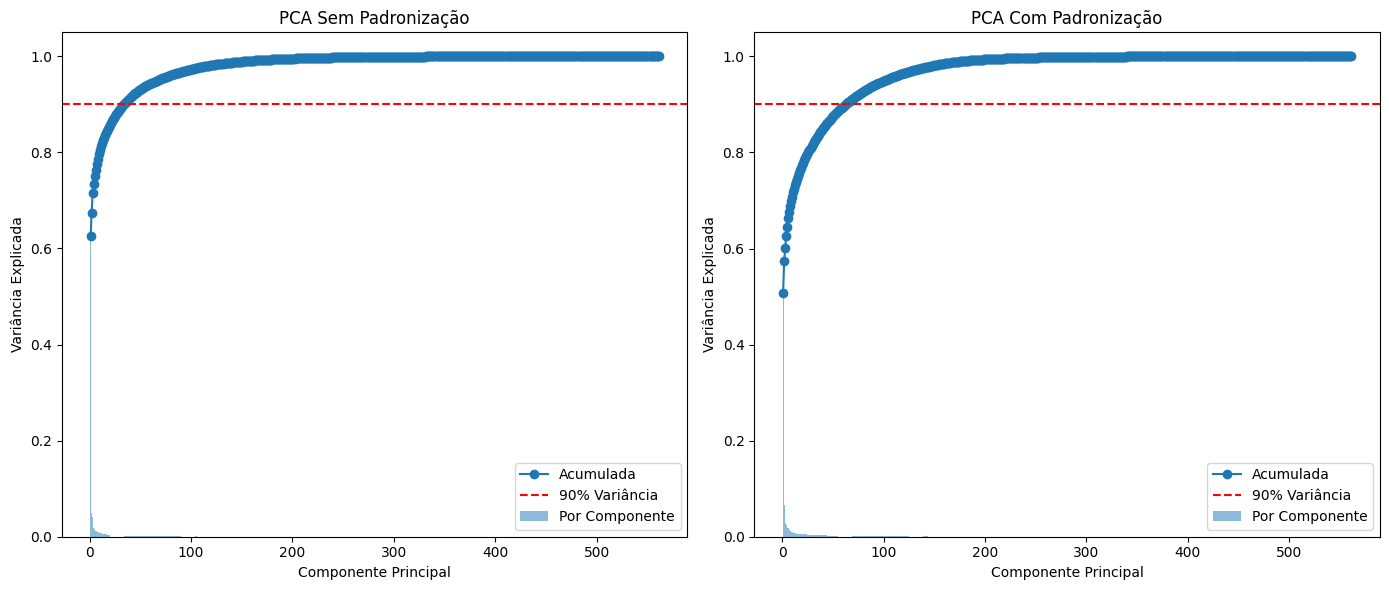

Número de componentes para explicar 90% da variância (Sem Padronização): 34
Número de componentes para explicar 90% da variância (Com Padronização): 63
CPU times: total: 2.8 s
Wall time: 2.93 s


In [28]:
%%time

# Sem padronização
pca_sem_padronizacao = PCA()
pca_sem_padronizacao.fit(X_train)

# Com padronização
scaler = StandardScaler()
X_train_padronizado = scaler.fit_transform(X_train)

pca_com_padronizacao = PCA()
pca_com_padronizacao.fit(X_train_padronizado)

# Variância explicada por componente (sem padronização)
variancia_explicada_sem = pca_sem_padronizacao.explained_variance_ratio_
variancia_acumulada_sem = np.cumsum(variancia_explicada_sem)

# Variância explicada por componente (com padronização)
variancia_explicada_com = pca_com_padronizacao.explained_variance_ratio_
variancia_acumulada_com = np.cumsum(variancia_explicada_com)

# Determinar o número de componentes para 90% da variância
componentes_90_sem = np.argmax(variancia_acumulada_sem >= 0.9) + 1
componentes_90_com = np.argmax(variancia_acumulada_com >= 0.9) + 1

# Criar DataFrame para facilitar a visualização
resultados = pd.DataFrame({
    'Componente': range(1, len(variancia_explicada_sem) + 1),
    'Variância Explicada (Sem Padronização)': variancia_explicada_sem,
    'Variância Explicada Acumulada (Sem Padronização)': variancia_acumulada_sem,
    'Variância Explicada (Com Padronização)': variancia_explicada_com,
    'Variância Explicada Acumulada (Com Padronização)': variancia_acumulada_com
})

# Exibir os resultados
display(resultados)

# Visualizar os gráficos
plt.figure(figsize=(14, 6))

# Sem padronização
plt.subplot(1, 2, 1)
plt.plot(range(1, len(variancia_explicada_sem) + 1), variancia_acumulada_sem, marker='o', label='Acumulada')
plt.bar(range(1, len(variancia_explicada_sem) + 1), variancia_explicada_sem, alpha=0.5, label='Por Componente')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variância')
plt.title('PCA Sem Padronização')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')
plt.legend()

# Com padronização
plt.subplot(1, 2, 2)
plt.plot(range(1, len(variancia_explicada_com) + 1), variancia_acumulada_com, marker='o', label='Acumulada')
plt.bar(range(1, len(variancia_explicada_com) + 1), variancia_explicada_com, alpha=0.5, label='Por Componente')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variância')
plt.title('PCA Com Padronização')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')
plt.legend()

plt.tight_layout()
plt.show()

# Exibir o número de componentes para 90% da variância
print(f"Número de componentes para explicar 90% da variância (Sem Padronização): {componentes_90_sem}")
print(f"Número de componentes para explicar 90% da variância (Com Padronização): {componentes_90_com}")

### Análise: PCA com e sem Padronização

### **1. Variância Explicada por Componente**
#### **Sem Padronização**
- A **primeira componente principal** domina a análise, explicando **62.55%** da variância.
- As componentes subsequentes explicam frações significativamente menores (a segunda explica apenas **4.91%** da variância).

#### **Com Padronização**
- A variância explicada é distribuída de forma mais uniforme entre os componentes principais:
  - A **primeira componente principal** explica **57.08%** da variância.
  - A segunda explica **5.73%**, com as demais contribuindo de forma gradual.

---

### **2. Variância Explicada Acumulada por Componente**
#### **Sem Padronização**
- A variância acumulada atinge **90%** rapidamente, com apenas **34 componentes**.
- Esse comportamento reflete o impacto das variáveis de maior escala, que dominam o PCA.

#### **Com Padronização**
- A variância acumulada cresce de forma mais gradual, alcançando **90%** apenas com **63 componentes**.
- Isso reflete uma análise mais equilibrada entre as variáveis, devido à padronização.

---

### **3. Variância Percentual por Componente**
#### **Sem Padronização**
- A primeira componente explica mais de **60%** da variância total.
- As demais componentes contribuem com menos de **1.8%** cada, a partir da terceira componente.

#### **Com Padronização**
- A primeira componente explica cerca de **57%** da variância, com as demais componentes apresentando contribuições mais significativas em comparação ao cenário sem padronização.

---

### **4. Variância Percentual Acumulada por Componente**
#### **Sem Padronização**
- Em **10 componentes**, a variância acumulada já ultrapassa **75%**.
- O crescimento é rápido, com as primeiras componentes dominando a análise.

#### **Com Padronização**
- Em **10 componentes**, a variância acumulada chega a **66.27%**, crescendo de forma mais uniforme e distribuída entre as variáveis.

---

### **5. Quantas Componentes para Explicar 90% da Variância?**
- **Sem Padronização**: Apenas **34 componentes** são necessários para explicar 90% da variância, devido à dominância das variáveis de maior escala.
- **Com Padronização**: São necessários **63 componentes** para explicar 90% da variância, pois a padronização distribui a importância entre as variáveis.

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [23]:
%%time

# PCA com 10 componentes principais
pca_10_sem_padronizacao = PCA(n_components=10)
X_train_pca_sem = pca_10_sem_padronizacao.fit_transform(X_train)
X_test_pca_sem = pca_10_sem_padronizacao.transform(X_test)

pca_10_com_padronizacao = PCA(n_components=10)
X_train_pca_com = pca_10_com_padronizacao.fit_transform(X_train_padronizado)
X_test_pca_com = pca_10_com_padronizacao.transform(scaler.transform(X_test))

# Modelo de árvore de decisão
modelo_sem_padronizacao = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
modelo_com_padronizacao = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)

# Treinar e prever (sem padronização)
modelo_sem_padronizacao.fit(X_train_pca_sem, y_train)
y_train_pred_sem = modelo_sem_padronizacao.predict(X_train_pca_sem)
y_test_pred_sem = modelo_sem_padronizacao.predict(X_test_pca_sem)

# Treinar e prever (com padronização)
modelo_com_padronizacao.fit(X_train_pca_com, y_train)
y_train_pred_com = modelo_com_padronizacao.predict(X_train_pca_com)
y_test_pred_com = modelo_com_padronizacao.predict(X_test_pca_com)

# Avaliar acurácia
acuracia_train_sem = accuracy_score(y_train, y_train_pred_sem)
acuracia_test_sem = accuracy_score(y_test, y_test_pred_sem)

acuracia_train_com = accuracy_score(y_train, y_train_pred_com)
acuracia_test_com = accuracy_score(y_test, y_test_pred_com)

# Exibir os resultados
print("Resultados:")
print(f"Acurácia na base de treino (Sem Padronização): {acuracia_train_sem:.4f}")
print(f"Acurácia na base de teste (Sem Padronização): {acuracia_test_sem:.4f}")
print(f"Acurácia na base de treino (Com Padronização): {acuracia_train_com:.4f}")
print(f"Acurácia na base de teste (Com Padronização): {acuracia_test_com:.4f}")

Resultados:
Acurácia na base de treino (Sem Padronização): 0.8927
Acurácia na base de teste (Sem Padronização): 0.8242
Acurácia na base de treino (Com Padronização): 0.8587
Acurácia na base de teste (Com Padronização): 0.7672
CPU times: total: 719 ms
Wall time: 649 ms


### Comparação de Árvores de Decisão com PCA

### 1. Desempenho da Árvore sem Padronização
- A árvore de decisão treinada com dados **não padronizados** apresentou **melhor desempenho** em ambas as bases:
  - **Treino**: 89.27%
  - **Teste**: 82.42%
- Isso ocorre porque, sem padronização, as variáveis de maior escala tiveram um impacto maior na análise, resultando em uma maior variância explicada pelas primeiras componentes principais. Isso permitiu capturar melhor os padrões dos dados.

### 2. Desempenho da Árvore com Padronização
- A árvore de decisão treinada com **dados padronizados** teve um desempenho inferior:
  - **Treino**: 85.87%
  - **Teste**: 76.72%
- A padronização resultou em uma distribuição mais uniforme da variância entre os componentes, mas pode ter diluído a influência de variáveis altamente informativas, prejudicando o desempenho geral.

### 3. Generalização
- Ambos os modelos mostram uma diferença esperada entre as acurácias de treino e teste, com desempenho ligeiramente inferior na base de teste, o que é indicativo de generalização.
- A árvore **sem padronização** demonstrou uma melhor capacidade de generalização, com menor queda de desempenho entre treino e teste.